In [1]:
import numpy as np
import pandas as pd
from fullfrlm import flow_refueling_location_model
import pickle
import networkx as nx
df_h = pickle.load(open("data/revised_cleaning_results/harbour_data_100.p", "rb"))

In [33]:
df_h

,Unnamed: 0,country,city_abbr,city_full,function,coords,harbour_code,lat,lon,harbour_node
0,78676,NL,ABL,Alblasserdam,1-------,nan,NLABL,51.861514,4.657490,8866686
1,78678,NL,ALK,Alkmaar,123-----,5238N 00445E,NLALK,52.633333,4.750000,8861625
2,78680,NL,ALM,Almelo,123-----,5221N 00640E,NLALM,52.350000,6.666667,8866425
3,78682,NL,AER,Almere,1-3--6--,5222N 00513E,NLAER,52.366667,5.216667,8864005
4,78685,NL,APN,Alphen aan den Rijn,123-----,5208N 00440E,NLAPN,52.133333,4.666667,8863360
...,...,...,...,...,...,...,...,...,...,...
65,80378,NL,WTE,West-Terschelling,1-------,nan,NLWTE,53.362705,5.216893,8865605
66,80438,NL,WMO,Wormer,1-3-----,5230N 00449E,NLWMO,52.500000,4.816667,8866889
67,80450,NL,ZAA,Zaandam,123-----,nan,NLZAA,52.442040,4.829199,8866889
68,80514,NL,ZWI,Zwijndrecht,123-----,nan,NLZWI,51.810598,4.627272,8865003


In [34]:
total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_abm, flows = flow_refueling_location_model(1, 50000, 100, 5, 5, 30, vis=False)

Optimal


In [48]:
nodes = []
for route in non_zero_flows.keys():
    nodes += paths[route]

nodes = list(set(nodes))

In [49]:
df_nodes = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')

In [50]:
df_nodes = df_nodes.loc[df_nodes.index.isin(nodes)]

In [51]:
df_nodes.fillna(0, inplace=True)
df_nodes['model_type'] =df_nodes.n.apply(lambda x: "harbour" if ((len(str(x))>4) and (x in df_h.harbour_node.unique())) else x)
df_nodes.model_type = df_nodes.model_type.apply(lambda x: "inserted_node" if x==0 else x)
df_nodes.model_type = df_nodes.model_type.apply(lambda x: "intermediate_node" if str(x).isdigit() else x)

In [52]:
def cs_harbour_or_both(col1, col2):
    to_r = col2
    if col1 ==0:
        if col2 == 'inserted_node':
            to_r = 'charging_station'
        else:
            to_r = 'harbour_with_charging'
    return to_r



In [53]:
df_nodes['index1'] = df_nodes.index
df_nodes['charging_stations'] = df_nodes.index1.apply(lambda x: optimal_facilities[x] if (x in df_h.harbour_node.unique()) or (len(str(x)) == 3) else 0)
df_nodes.model_type = df_nodes.apply(lambda x: cs_harbour_or_both(x.charging_stations, x.model_type), axis=1)
df_nodes.drop(columns=['index1', 'n', 'geometry', 'Wkt'], inplace=True)

In [54]:
df_nodes.reset_index(inplace=True)
df_nodes.rename(columns={'index':'node_id'}, inplace=True)
df_nodes['source'] = np.nan
df_nodes['target'] = np.nan
df_nodes['length_m'] = np.nan

In [55]:
df_links = nx.to_pandas_edgelist(G)

In [56]:
df_links = df_links.loc[:, ['source', 'target', 'length_m']]
df_links['X'] = np.nan
df_links['Y'] = np.nan
df_links['node_id'] = np.nan
df_links['charging_stations'] = np.nan
df_links['model_type'] = 'link'

In [57]:
df_nodes

,node_id,X,Y,model_type,charging_stations,source,target,length_m
0,30986055,5.402429,53.177448,intermediate_node,0.0,NaN,NaN,NaN
1,8866889,4.832089,52.431155,harbour,0.0,NaN,NaN,NaN
2,30984595,4.572310,51.692559,harbour_with_charging,5.0,NaN,NaN,NaN
3,8862690,5.525170,52.500915,intermediate_node,0.0,NaN,NaN,NaN
4,8867901,5.765900,52.583854,intermediate_node,0.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
86,113,5.210375,53.241520,charging_station,5.0,NaN,NaN,NaN
87,122,6.888270,53.384504,inserted_node,0.0,NaN,NaN,NaN
88,130,5.682730,51.881516,charging_station,3.0,NaN,NaN,NaN
89,131,4.792471,52.531953,charging_station,1.0,NaN,NaN,NaN


In [58]:
df_abm = pd.concat([df_links, df_nodes])

In [59]:
df_abm

,source,target,length_m,X,Y,node_id,charging_stations,model_type
0,30986055,8867600,8380.518917,NaN,NaN,NaN,NaN,link
1,30986055,8864167,68.700608,NaN,NaN,NaN,NaN,link
2,30986055,8865756,2481.139176,NaN,NaN,NaN,NaN,link
3,11309058,8865990,18936.187403,NaN,NaN,NaN,NaN,link
4,11309058,8866775,11560.215727,NaN,NaN,NaN,NaN,link
...,...,...,...,...,...,...,...,...
86,NaN,NaN,NaN,5.210375,53.241520,113,5.0,charging_station
87,NaN,NaN,NaN,6.888270,53.384504,122,0.0,inserted_node
88,NaN,NaN,NaN,5.682730,51.881516,130,3.0,charging_station
89,NaN,NaN,NaN,4.792471,52.531953,131,1.0,charging_station


Optimal


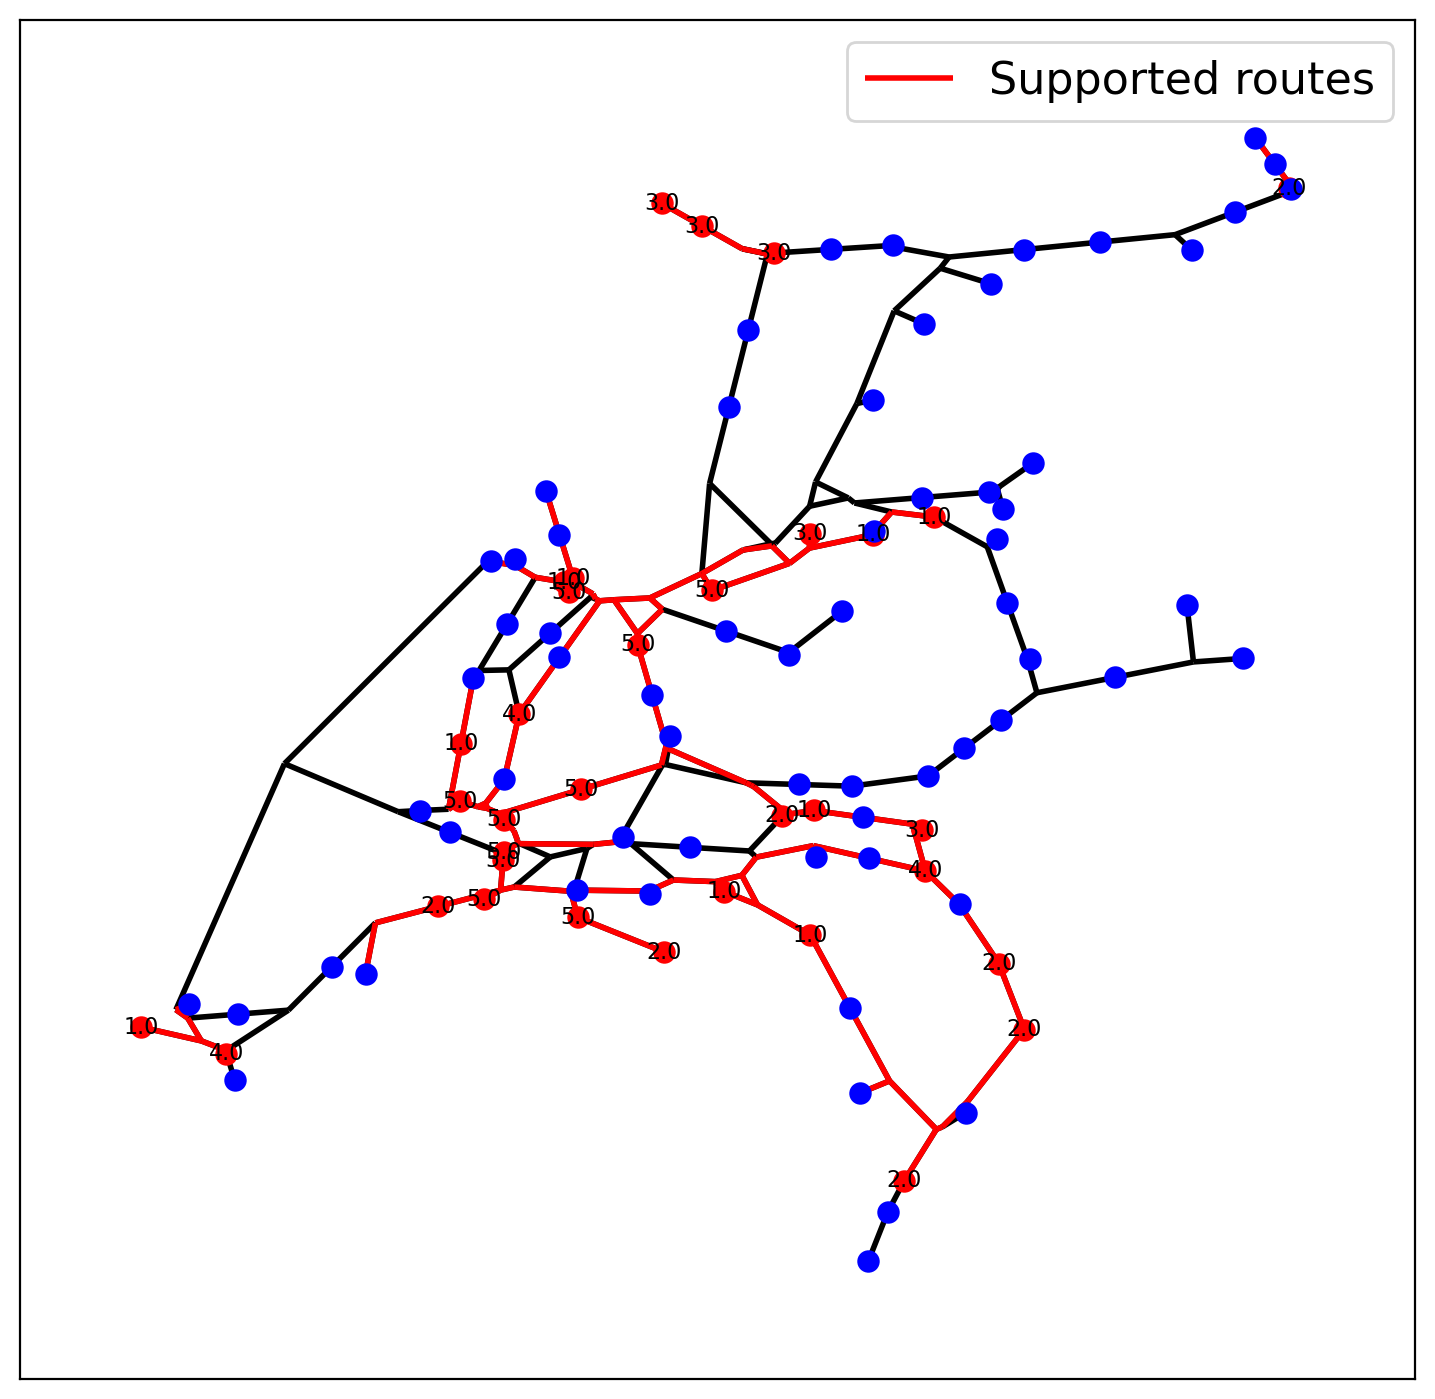

In [2]:
total_flow, fraction_captured_total, serveable_fraction, served_fraction, optimal_facilities, non_zero_flows, routes_supported, paths, G, df_abm, flows = flow_refueling_location_model(1, 100000, 100, 5, 5, 30, vis=True)

In [3]:
df_abm

,source,target,length_m,X,Y,node_id,charging_stations,model_type
0,30986055,8867600,8380.518917,NaN,NaN,NaN,NaN,link
1,30986055,8864167,68.700608,NaN,NaN,NaN,NaN,link
2,30986055,8865756,2481.139176,NaN,NaN,NaN,NaN,link
3,11309058,8865990,18936.187403,NaN,NaN,NaN,NaN,link
4,11309058,8866775,11560.215727,NaN,NaN,NaN,NaN,link
...,...,...,...,...,...,...,...,...
121,NaN,NaN,NaN,5.700503,51.787230,115,0.0,charging_station
122,NaN,NaN,NaN,6.888270,53.384504,122,0.0,charging_station
123,NaN,NaN,NaN,5.682730,51.881516,130,0.0,charging_station
124,NaN,NaN,NaN,4.792471,52.531953,131,0.0,charging_station


In [4]:
pickle.dump(G, open("ABM/own_work/data/network.p", "wb"))
pickle.dump(paths, open("ABM/own_work/data/paths.p", "wb"))
pickle.dump(flows, open("ABM/own_work/data/total_flow.p", "wb"))
pickle.dump(df_abm, open("ABM/own_work/data/df_abm.p", "wb"))